## Imports and routines

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import sys
import os
import importlib
import shutil
import numpy as np
import threading
# import keras

import selectivesearch
reload(selectivesearch)
from selectivesearch import get_selective_search_regions

import pickle
import PIL
import utils.general
from utils.general import *

import pascal_voc_reader

import bbox_transform
reload(bbox_transform)
from bbox_transform import *

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as weight_init
import torch.nn.functional as F

import rcnn_utils
reload(rcnn_utils)
from rcnn_utils import *
import data_utils
reload(data_utils)
from data_utils import *
from nms.nms_wrapper import nms

from IPython.core.debugger import Tracer
from IPython.display import clear_output

# %matplotlib inline

import voc_eval; reload(voc_eval)
from voc_eval import voc_eval

import dataset; reload(dataset); from dataset import *

NameError: name 'reload' is not defined

In [3]:

import argparse
import pprint
import time, os, sys


In [3]:
def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Test a Fast R-CNN network')
    parser.add_argument('--gpu', dest='gpu_id', help='GPU id to use',
                        default=0, type=int)
    parser.add_argument('--def', dest='prototxt',
                        help='prototxt file defining the network',
                        default='../rbgirshick/py-faster-rcnn/models/pascal_voc/VGG16/fast_rcnn/test.prototxt',
                        type=str)
    parser.add_argument('--net', dest='caffemodel',
                        help='model to test',
                        default='../rbgirshick/py-faster-rcnn/output/default/voc_2007_trainval/vgg16_fast_rcnn_iter_40000.caffemodel',
                        type=str)
    parser.add_argument('--cfg', dest='cfg_file',
                        help='optional config file', default=None, type=str)
    parser.add_argument('--wait', dest='wait',
                        help='wait until net file exists',
                        default=True, type=bool)
    parser.add_argument('--imdb', dest='imdb_name',
                        help='dataset to test',
                        default='voc_2007_trainval', type=str)
    parser.add_argument('--comp', dest='comp_mode', help='competition mode',
                        action='store_true')
    parser.add_argument('--set', dest='set_cfgs',
                        help='set config keys', default=None,
                        nargs=argparse.REMAINDER)
    parser.add_argument('--vis', dest='vis', help='visualize detections',
                        action='store_true')
    parser.add_argument('--num_dets', dest='max_per_image',
                        help='max number of detections per image',
                        default=100, type=int)

    parser.add_argument('-f', dest='_',
                        help='')

    args = parser.parse_args()
    return args

In [4]:
args = parse_args()

In [6]:

this_dir = '.'
def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

caffe_path = os.path.join(this_dir, '../rbgirshick/py-faster-rcnn', 'caffe-fast-rcnn', 'python')
add_path(caffe_path)


In [7]:
import caffe

In [8]:

caffe.set_mode_gpu()
caffe.set_device(args.gpu_id)

In [11]:
args

Namespace(_='/home/slav/.local/share/jupyter/runtime/kernel-eef351d4-1a03-4729-bc16-b01a195a8f3a.json', caffemodel='../rbgirshick/py-faster-rcnn/output/default/voc_2007_trainval/vgg16_fast_rcnn_iter_40000.caffemodel', cfg_file=None, comp_mode=False, gpu_id=0, imdb_name='voc_2007_trainval', max_per_image=100, prototxt='../rbgirshick/py-faster-rcnn/models/pascal_voc/VGG16/fast_rcnn/test.prototxt', set_cfgs=None, vis=False, wait=True)

In [1]:
args.prototxt

NameError: name 'args' is not defined

In [ ]:

net = caffe.Net('../rbgirshick/py-faster-rcnn/models/pascal_voc/VGG16/fast_rcnn/test.prototxt', 
                '../rbgirshick/py-faster-rcnn/output/default/voc_2007_trainval/vgg16_fast_rcnn_iter_40000.caffemodel',
                caffe.TEST)


In [ ]:

net.name = os.path.splitext(os.path.basename(args.caffemodel))[0]

In [36]:
t = torch.randn(1, 3, 9, 9)

In [40]:
def im_list_to_blob(ims):
    """Convert a list of images into a network input.
    Assumes images are already prepared (means subtracted, BGR order, ...).
    """
    max_shape = np.array([im.shape for im in ims]).max(axis=0)
    num_images = len(ims)
    blob = np.zeros((num_images, max_shape[0], max_shape[1], 3),
                    dtype=np.float32)
    for i in range(num_images):
        im = ims[i]
        blob[i, 0:im.shape[0], 0:im.shape[1], :] = im
    # Move channels (axis 3) to axis 1
    # Axis order will become: (batch elem, channel, height, width)
    channel_swap = (0, 3, 1, 2)
    blob = blob.transpose(channel_swap)
    return blob

In [41]:
def _get_image_blob(im):
    # from rgb to bgr
    indices = torch.LongTensor([2, 1, 0])
    im.index_select(1, indices)
    
    return im_list_to_blob[im.cpu().numpy()[0]]
    

In [42]:
def get_blob(image, rois):
    """Convert an image and RoIs within that image into network inputs."""
    blobs = {'data' : None, 'rois' : None}
    blobs['data'] = _get_image_blob(im)
    blobs['rois'] = rois
    return blobs

In [43]:
def unnormalize_deltas(deltas, mean, std):
    ''' Unnormalize deltas using mean and std.
    Args:
        deltas: A ndarray with size (batch_size, num_fg_classes * 4)
        mean: The mean of the normalized targets
        std: The std of the normalized targets
    Returns:
        The unnormalized deltas.
    '''
    # Mean and std skip first 4 values (its the background class).
    # Then get shaped into num_fg_classes * 4 to be added to the deltas.
    means = mean[4:]
    stds = std[4:]
    return deltas * stds + means


def test_image(image, rois, targets_mean, targets_std,
               top_class_only=True,
               class_detection_thresh=0.05,
               nms_thresh=0.3):
    ''' Test a single image on the net.
    Args:
        image: A preprocessed image or precomputed features of 
            the image. As ndarray.
        rois: RoIs for the image. Ndarray: (image_index, x1, y1, x2, y2)
        targets_mean: The mean of all targets.
        targets_std: The std of all targets.
        top_class_only: Whether to use only top class for each roi,
            or any class over a certain threshhold.
        class_detection_thresh: If the softmax for this class is 
            above class_detection_thresh, it's considered detected
            in the roi.
    '''
    # from CxHxW to WxHxC
    im_size = np.asarray(image.size())[[3, 2, 1]]
    # image_var = np_to_var(image.astype(np.float32))
    # rois_var = np_to_var(rois.astype(np.int32))
#     image_var = Variable(image.cuda(), volatile=True)
#     rois_var = Variable(rois[0].float().cuda(), volatile=True)
    blobs = get_blob(image, rois[0])

    # reshape network inputs
    net.blobs['data'].reshape(*(blobs['data'].shape))
    net.blobs['rois'].reshape(*(blobs['rois'].shape))

    # do forward
    forward_kwargs = {'data': blobs['data'].astype(np.float32, copy=False)}
    forward_kwargs['rois'] = blobs['rois'].astype(np.float32, copy=False)
    blobs_out = net.forward(**forward_kwargs)

    scores = blobs_out['cls_prob']
    deltas = blobs_out['bbox_pred']
    
    deltas = unnormalize_deltas(deltas, targets_mean, targets_std)
    # transform rois using predicted deltas
    boxes = rois[0, :, 1:].cpu().numpy()
    bboxes_inv_transformed = bbox_transform_inv(boxes, deltas)

#     # Run the img through the network
#     out = model(image_var, rois_var)
#     # predicted deltas
#     deltas = out[1].data.cpu().numpy()
#     deltas = unnormalize_deltas(deltas, targets_mean, targets_std)

#     # transform rois using predicted deltas
#     boxes = rois[0, :, 1:].cpu().numpy()
#     bboxes_inv_transformed = bbox_transform_inv(boxes, deltas)

#     class_probas, class_indexes = torch.max(out[0], 1)
#     indexes_np = np.squeeze(class_indexes.data.cpu().numpy())
# #     print('Total FG RoIs Detected: ', np.sum(indexes_np > 0))

#     scores = out[0].data.cpu().numpy()
#     scores = np.exp(scores)

    # clip rois to image size
    bboxes_inv_transformed = clip_boxes(bboxes_inv_transformed,
                                        im_size)

    all_boxes = nms_boxes(bboxes_inv_transformed, scores,
                          top_class_only=top_class_only,
                          class_detection_thresh=class_detection_thresh,
                          nms_thresh=nms_thresh)
    return all_boxes


def nms_boxes(boxes, scores, num_classes=21,
              top_class_only=False,
              class_detection_thresh=0.05,
              nms_thresh=0.3):
    all_boxes = [[] for _ in range(num_classes)]
    # skip j = 0, because it's the background class
    for class_id in range(1, num_classes):
        # Whether to use only the top class for each box or
        # all classes over a certain threshhold.
        if top_class_only:
            detection_criterion = (np.argmax(scores, axis=1) == class_id)
        else:
            detection_criterion = (
                scores[:, class_id] > class_detection_thresh)
        class_detected_indexes = np.where(detection_criterion)[0]

        cls_scores = scores[class_detected_indexes, class_id]
        class_box_start = (class_id - 1) * 4
        class_box_end = class_box_start + 4
        cls_boxes = boxes[class_detected_indexes,
                          class_box_start:class_box_end]

        cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])) \
            .astype(np.float32, copy=False)

        if len(cls_dets) > 1:
            keep = nms(cls_dets, nms_thresh, force_cpu=True)
            cls_dets = cls_dets[keep, :]
        all_boxes[class_id] = cls_dets
    return all_boxes


def get_display_boxes(all_boxes):
    display_boxes = []
    display_classes = []
    for class_id, class_boxes in enumerate(all_boxes):
        for box in class_boxes:
            display_boxes.append(box)
            display_classes.append(class_id)
    return np.asarray(display_boxes), np.asarray(display_classes)


def display_detections(rois, classes, sample, 
                       show_gt_boxes=True, 
                       class_id_to_name=None):
    ''' Display detected foreground rois for a sample.
    Args:
        rois: Detected RoIs as ndarray of (x, y, w, h)
        classes: Class labels of each RoI as ndarray of class_id.
        sample: A dict describing the sample that produced 
            the rois and classes.
        show_gt_boxes: Show the ground truth boxes as well.
        class_id_to_name: A dict mapping from a class id to a class name.
    '''
    detected_roi = np.append(rois,
                             classes[:, None],
                             axis=1)
    if show_gt_boxes:
        gt_boxes = sample['gt_boxes_xywh']
    else:
        gt_boxes = None

    image = Pascal_VOC.get_image(sample)

    for class_id in detected_roi[:, 5]:
        print(class_id_to_name[class_id])
    display_image_regions(image, detected_roi, gt_boxes,
                          class_id_to_name=class_id_to_name)

## Load data

In [14]:
def load_data():
    data_set = Pascal_VOC(data_path='../VOC/VOCdevkit/',
                          year='2007', set_name='trainval',
                          mode='test')

    dataloader = torch.utils.data.DataLoader(
        data_set, batch_size=1, shuffle=False, num_workers=0)

    data_iter = dataloader.__iter__()
    return data_set, dataloader, data_iter


try:
    del data_set
    del dataloader
    del data_iter
except:
    pass

data_set, dataloader, data_iter = load_data()

TypeError: super() takes at least 1 argument (0 given)

## Setup the network

In [4]:
# Init the model
try:
    del model
except NameError:
    pass

model = Fast_RCNN_model(dropout_p=0.1).cuda()
model.train(mode=False)
# fast_rcnn_weights_init(model)
load_weights(model, 'intermediate/voc/weights-regression-401.pth')

## Test a single image 

In [4]:
data_iter = dataloader.__iter__()


person
person
tvmonitor
tvmonitor
car


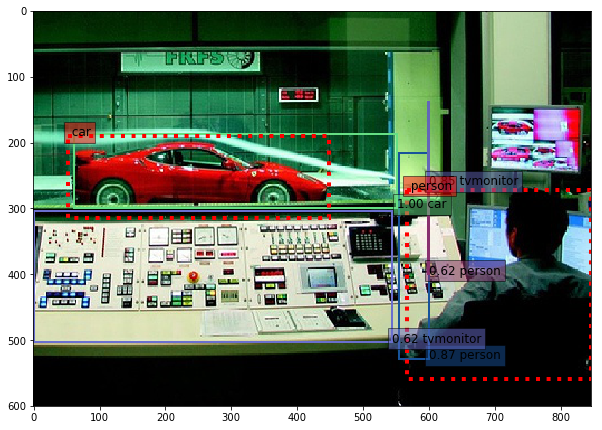

In [23]:
batch = next(data_iter)
sample_index, images, rois, = batch
sample_index = sample_index.cpu().numpy()[0]

all_boxes = test_image(images, rois, 
                       targets_mean=data_set.targets_mean, 
                       targets_std=data_set.targets_std, 
                       top_class_only=False,
                       class_detection_thresh=0.3, 
                       nms_thresh=0.1)

display_boxes, display_classes = get_display_boxes(all_boxes)

if len(display_boxes) == 0:
    print('Nothing detected for this image.')
else:
    display_detections(
        x1y1x2y2_to_xywh(display_boxes),
        display_classes,
        data_set.samples[sample_index], 
        show_gt_boxes=True, 
        class_id_to_name=data_set.class_id_to_name)

##  Test all images

In [5]:
def test(dataloader):

    n_batches = len(dataloader.dataset.samples) // 2
    
    all_boxes = [[[] for _ in range(n_batches)]
                 for _ in range(dataloader.dataset.num_classes)]
    data_iterator = dataloader.__iter__()
    for image_index in tqdm.tqdm_notebook(range(n_batches)):
        # Get next batch
        try:
            batch = next(data_iterator)
        except StopIteration:
            break
        sample_index, images, rois,  = batch
        sample_index = sample_index.cpu().numpy()[0]
        # Forward Pass
        image_boxes = test_image(images, rois, 
                               targets_mean=dataloader.dataset.targets_mean, 
                               targets_std=dataloader.dataset.targets_std, 
                               top_class_only=True,
                               class_detection_thresh=0.5, 
                               nms_thresh=0.15)
        
        for class_id, class_boxes in enumerate(image_boxes):
            all_boxes[class_id][image_index] = class_boxes

    return all_boxes

In [6]:
all_boxes = test(dataloader)

In [7]:
output_dir = 'intermediate/voc/'
det_file = os.path.join(output_dir, 'eval_detects.pkl')
with open(det_file, 'wb') as f:
    pickle.dump(all_boxes, f, pickle.HIGHEST_PROTOCOL)


In [4]:
output_dir = '../rbgirshick/py-faster-rcnn/output/default/voc_2007_trainval/vgg16_fast_rcnn_iter_40000/'
det_file = os.path.join(output_dir, 'detections.pkl')
with open(det_file, 'rb') as f:
    all_boxes = pickle.load(f)


## Evaluate the results

In [9]:
_classes = [data_set.class_id_to_name[index] 
            for index in range(data_set.num_classes)]
_devkit_path = '../VOC/VOCdevkit/'

NameError: name 'data_set' is not defined

In [ ]:
dataset_filenames = np.array(data_set.filenames[:5011])
names_only = [name.replace('./data/VOC2007/JPEGImages/',''
                          ).replace('.jpg', '')
              for name in dataset_filenames]
len(names_only)

In [10]:
# imageset_filename = 'slav_train.txt'
# save_dir = 'data/VOCdevkit/VOC2012/ImageSets/Main/'
# fullpath = os.path.join(save_dir, imageset_filename)
# with open(fullpath, 'w') as f:
#     for line in names_only:
#         f.write('{:s}\n'.format(line))

In [13]:
_write_voc_results_file(_classes, names_only, all_boxes, _devkit_path)

NameError: name '_classes' is not defined

In [15]:
imageset_filename = 'trainval.txt'
_do_python_eval(_devkit_path, _classes, imageset_filename=imageset_filename)

AP for person = 0.0909
AP for bottle = 0.0005
AP for tvmonitor = 0.0019
AP for boat = 0.0165
AP for chair = 0.0005
AP for sofa = 0.0455
AP for cow = 0.0008
AP for diningtable = 0.0000
AP for train = 0.0012
AP for pottedplant = 0.0028
AP for aeroplane = 0.0130
AP for motorbike = 0.0455
AP for car = 0.0053
AP for cat = 0.0455
AP for dog = 0.0091
AP for bird = 0.0021
AP for bicycle = 0.0146
AP for horse = 0.0013
AP for bus = 0.0036
AP for sheep = 0.0031
Mean AP = 0.0152
~~~~~~~~
Results:
0.091
0.001
0.002
0.017
0.001
0.045
0.001
0.000
0.001
0.003
0.013
0.045
0.005
0.045
0.009
0.002
0.015
0.001
0.004
0.003
0.015
~~~~~~~~

--------------------------------------------------------------
Results computed with the **unofficial** Python eval code.
Results should be very close to the official MATLAB eval code.
Recompute with `./tools/reval.py --matlab ...` for your paper.
-- Thanks, The Management
--------------------------------------------------------------


In [10]:
def _write_voc_results_file(classes, filenames, all_boxes, _devkit_path):
    for cls_ind, cls in enumerate(classes):
        if cls == 'bg':
            continue
        print('Writing {} VOC results file'.format(cls))
        filename = _get_voc_results_file_template(_devkit_path).format(cls)
        with open(filename, 'wt') as f:
            for im_ind, index in enumerate(filenames):
                dets = all_boxes[cls_ind][im_ind]
                if dets == []:
                    continue
                # the VOCdevkit expects 1-based indices
                for k in range(dets.shape[0]):
                    f.write('{:s} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.
                            format(index, dets[k, -1],
                                   dets[k, 0] + 1, dets[k, 1] + 1,
                                   dets[k, 2] + 1, dets[k, 3] + 1))


In [11]:
def _get_voc_results_file_template(_devkit_path):
    # VOCdevkit/results/VOC2007/Main/<comp_id>_det_test_aeroplane.txt
    filename = '_det_' + 'trainval' + '_{:s}.txt'
    path = os.path.join(
        _devkit_path,
        'results',
        'VOC2007',
        'Main',
        filename)
    return path


In [12]:
def _do_python_eval(_devkit_path, _classes, output_dir = 'output', 
                   imageset_filename='trainval.txt'):
    annopath = os.path.join(
        _devkit_path,
        'VOC2007',
        'Annotations',
        '{:s}.xml')
    imagesetfile = os.path.join(
        _devkit_path,
        'VOC2007',
        'ImageSets',
        'Main',
        imageset_filename)

    cachedir = os.path.join(_devkit_path, 'annotations_cache')
    aps = []
    # The PASCAL VOC metric changed in 2010
    use_07_metric = True

    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    for i, cls in enumerate(_classes):
        if cls == 'bg':
            continue
        filename = _get_voc_results_file_template(_devkit_path).format(cls)
        rec, prec, ap = voc_eval(
            filename, annopath, imagesetfile, cls, cachedir, ovthresh=0.5,
            use_07_metric=use_07_metric)
        aps += [ap]
        print('AP for {} = {:.4f}'.format(cls, ap))
        with open(os.path.join(output_dir, cls + '_pr.pkl'), 'wb') as f:
            pickle.dump({'rec': rec, 'prec': prec, 'ap': ap}, f)
    print('Mean AP = {:.4f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('Results:')
    for ap in aps:
        print('{:.3f}'.format(ap))
    print('{:.3f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('')
    print('--------------------------------------------------------------')
    print('Results computed with the **unofficial** Python eval code.')
    print('Results should be very close to the official MATLAB eval code.')
    print('Recompute with `./tools/reval.py --matlab ...` for your paper.')
    print('-- Thanks, The Management')
    print('--------------------------------------------------------------')


In [258]:
# TODO check how we perform with and without regression targets